In [1]:
from json import *
import pandas as pd
from time import sleep
from kafka import KafkaProducer

In [2]:
producer = KafkaProducer(bootstrap_servers='localhost:9092', value_serializer=lambda x: dumps(x).encode('utf-8'))

In [6]:
df = pd.read_csv('pokemondata.csv')

In [7]:
df.head()

,index,name,rank,generation,evolves_from,type1,type2,hp,atk,def,spatk,spdef,speed,total,height,weight,abilities,desc
0,1,bulbasaur,ordinary,generation-i,nothing,grass,poison,45,49,49,65,65,45,318,7.0,69,overgrow chlorophyll,A strange seed was planted on its back at birt...
1,2,ivysaur,ordinary,generation-i,bulbasaur,grass,poison,60,62,63,80,80,60,405,10.0,130,overgrow chlorophyll,"When the bulb on its back grows large, it appe..."
2,3,venusaur,ordinary,generation-i,ivysaur,grass,poison,80,82,83,100,100,80,525,20.0,1000,overgrow chlorophyll,The plant blooms when it is absorbing solar en...
3,4,charmander,ordinary,generation-i,nothing,fire,NaN,39,52,43,60,50,65,309,6.0,85,blaze solar-power,"Obviously prefers hot places. When it rains, s..."
4,5,charmeleon,ordinary,generation-i,charmander,fire,NaN,58,64,58,80,65,80,405,11.0,190,blaze solar-power,"When it swings its burning tail, it elevates t..."


In [11]:
from kafka import KafkaProducer
import csv

# Initialize Kafka producer
producer = KafkaProducer(bootstrap_servers='localhost:9092')

# Read data from .csv file and publish to Kafka topic
with open('pokemondata.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        # Send each row to Kafka topic
        producer.send('pokemon-data', ','.join(row).encode('utf-8'))

# Close the Kafka producer
producer.close()

In [ ]:
producer.flush()

In [12]:
from time import sleep
from json import loads
from kafka import KafkaConsumer
import json
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import mean, stddev, median, desc, when, explode, split, collect_list, count, col, avg
from pyspark.sql import DataFrameStatFunctions
from pyspark.sql.window import Window

In [14]:
spark = SparkSession.builder \
    .appName("PokemonAnalysis") \
    .getOrCreate()

In [15]:
# Define schema to parse JSON from Kafka
schema = StructType([
    StructField("index", IntegerType()),
    StructField("name", StringType()),
    StructField("rank", StringType()),
    StructField("generation", StringType()),
    StructField("evolves_from", StringType()),
    StructField("type1", StringType()),
    StructField("type2", StringType()),
    StructField("hp", IntegerType()),
    StructField("atk", IntegerType()),
    StructField("def", IntegerType()),
    StructField("spatk", IntegerType()),
    StructField("spdef", IntegerType()),
    StructField("speed", IntegerType()),
    StructField("total", IntegerType()),
    StructField("height", IntegerType()),
    StructField("weight", IntegerType()),
    StructField("abilities", StringType()),
    StructField("desc", StringType())
])

In [16]:
consumer = KafkaConsumer ('pokemon-data', bootstrap_servers='localhost:9092', value_deserializer=lambda x: loads (x.decode('utf-8')))

In [17]:
#df Dataframe()
print(consumer)
consumer

In [20]:
# Load the dataset
df = spark.read.csv("pokemondata.csv", header=True, schema=schema)

In [23]:
#Goal1: Statistical Analysis of Base Stats: 
#Perform grouped statistics
grouped_stats = df.groupBy("generation").agg(
    mean("hp").alias("avg_hp"),
    mean("atk").alias("avg_atk"),
    mean("def").alias("avg_def"),
    mean("spatk").alias("avg_spatk"),
    mean("spdef").alias("avg_spdef"),
    mean("speed").alias("avg_speed"),
    mean("total").alias("avg_total"),
    stddev("hp").alias("stddev_hp"),
    stddev("atk").alias("stddev_atk"),
    stddev("def").alias("stddev_def"),
    stddev("spatk").alias("stddev_spatk"),
    stddev("spdef").alias("stddev_spdef"),
    stddev("speed").alias("stddev_speed"),
    stddev("total").alias("stddev_total"),
    median("hp").alias("median_hp"),
    median("atk").alias("median_atk"),
    median("def").alias("median_def"),
    median("spatk").alias("median_spatk"),
    median("spdef").alias("median_spdef"),
    median("speed").alias("median_speed"),
    median("total").alias("median_total")
)

# Show the grouped statistics
grouped_stats.show()

+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+----------+----------+------------+------------+------------+------------+
|     generation|           avg_hp|          avg_atk|          avg_def|        avg_spatk|        avg_spdef|         avg_speed|         avg_total|         stddev_hp|        stddev_atk|        stddev_def|      stddev_spatk|      stddev_spdef|      stddev_speed|      stddev_total|median_hp|median_atk|median_def|median_spatk|median_spdef|median_speed|median_total|
+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------

In [24]:
#Goal 2: Physical Attributes Exploration
df = df.dropna(subset=["height", "weight"])

# Calculate correlation between height, weight, and base stats
correlation_height_weight = df.stat.corr("height", "weight")
correlation_height_base_stats = df.stat.corr("height", "total")
correlation_weight_base_stats = df.stat.corr("weight", "total")

# Display the correlations
print("Correlation between height and weight:", correlation_height_weight)
print("Correlation between height and total base stats:", correlation_height_base_stats)
print("Correlation between weight and total base stats:", correlation_weight_base_stats)

Correlation between height and weight: 0.6321557457511485
Correlation between height and total base stats: 0.50566238634626
Correlation between weight and total base stats: 0.45634981099662386


In [25]:
#Goal 3: Ranking Analysis
rank_stats = df.groupBy("rank").agg(
    mean("hp").alias("avg_hp"),
    mean("atk").alias("avg_atk"),
    mean("def").alias("avg_def"),
    mean("spatk").alias("avg_spatk"),
    mean("spdef").alias("avg_spdef"),
    mean("speed").alias("avg_speed"),
    mean("total").alias("avg_total")
)

# Order by rank to identify patterns or trends
rank_stats = rank_stats.orderBy(desc("rank"))

# Display the ranking analysis
rank_stats.show()

+---------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|     rank|           avg_hp|           avg_atk|           avg_def|         avg_spatk|         avg_spdef|        avg_speed|        avg_total|
+---------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
| ordinary|68.16132596685082| 75.77348066298343| 70.64198895027624| 67.27182320441989| 67.45524861878454| 64.8220994475138|414.1259668508287|
| mythical|             88.0|103.34782608695652| 98.91304347826087|106.82608695652173| 95.26086956521739|93.73913043478261|586.0869565217391|
|legendary|95.32857142857142|103.21428571428571| 97.34285714285714|             102.4|100.71428571428571|95.71428571428571|594.7142857142857|
|     baby|53.94736842105263|  39.1578947368421|38.421052631578945| 45.10526315789474|56.473684210526315|41.36842105263158|274.4736842105263|
+-----

In [26]:
#Goal 4: Generation Trend Analysis
df = df.withColumn("type", explode(split(col("type1"), ",")))
df = df.withColumn("ability", explode(split(col("abilities"), ",")))

# Group by generation and calculate average base stats, count of types, and count of abilities
generation_stats = df.groupBy("generation").agg(
    mean("hp").alias("avg_hp"),
    mean("atk").alias("avg_atk"),
    mean("def").alias("avg_def"),
    mean("spatk").alias("avg_spatk"),
    mean("spdef").alias("avg_spdef"),
    mean("speed").alias("avg_speed"),
    count("type").alias("type_count"),
    count("ability").alias("ability_count")
)

# Display the generation trend analysis
generation_stats.show()

+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------+-------------+
|     generation|           avg_hp|          avg_atk|          avg_def|        avg_spatk|        avg_spdef|        avg_speed|type_count|ability_count|
+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------+-------------+
|   generation-i|64.36486486486487|73.07432432432432|68.52702702702703|67.48648648648648| 66.3445945945946|68.94594594594595|       148|          148|
|  generation-vi|68.91666666666667|             72.5|75.08333333333333|72.54166666666667|74.58333333333333|65.68055555555556|        72|           72|
|  generation-ii|70.73737373737374|68.29292929292929|69.28282828282828|64.54545454545455|71.75757575757575|61.37373737373738|        99|           99|
| generation-vii|71.01136363636364|84.77272727272727|78.72727272727273|74.95454545454545|74.56

In [27]:
#Goal 5: Weight-Class Segmentation
df = df.withColumn("weight_class", 
                   when((col("weight") < 50), "Lightweight")
                   .when((col("weight") >= 50) & (col("weight") < 100), "Middleweight")
                   .otherwise("Heavyweight"))

# Group by weight class and analyze factors like base stats, abilities, and evolutionary patterns
weight_class_analysis = df.groupBy("weight_class").agg(
    {"hp": "avg", "atk": "avg", "def": "avg", 
     "spatk": "avg", "spdef": "avg", "speed": "avg", 
     "abilities": "count", "evolves_from": "count"}
)

# Display the weight class segmentation analysis
weight_class_analysis.show()

+------------+-----------------+-----------------+----------------+------------------+-------------------+-----------------+-----------------+-----------------+
|weight_class|       avg(spatk)|         avg(atk)|count(abilities)|        avg(spdef)|count(evolves_from)|         avg(def)|          avg(hp)|       avg(speed)|
+------------+-----------------+-----------------+----------------+------------------+-------------------+-----------------+-----------------+-----------------+
| Heavyweight|74.39673913043478| 85.4633152173913|             736| 74.91847826086956|                736| 78.5258152173913|76.91304347826087|71.02173913043478|
|Middleweight|       57.7109375|           57.625|             128|        57.4609375|                128|        57.859375|       53.6171875|          53.5625|
| Lightweight|60.26143790849673|56.49673202614379|             153|57.947712418300654|                153|55.87581699346405|51.87581699346405|59.98692810457516|
+------------+-----------------+--

In [28]:
#Goal 6: Descendants Analysis
descendants_analysis = df.groupBy("evolves_from").agg(
    collect_list("name").alias("descendants")
)

# Display the descendants analysis
descendants_analysis.show()

+------------+--------------------+
|evolves_from|         descendants|
+------------+--------------------+
|        abra|           [kadabra]|
|       aipom|           [ambipom]|
|      amaura|           [aurorus]|
|     anorith|           [armaldo]|
|      applin|[flapple, appletu...|
|      archen|          [archeops]|
|    arctibax|        [baxcalibur]|
|        aron|            [lairon]|
|    arrokuda|       [barraskewda]|
|        axew|           [fraxure]|
|     azurill|            [marill]|
|       bagon|           [shelgon]|
|      baltoy|           [claydol]|
|    barboach|          [whiscash]|
|    basculin|       [basculegion]|
|     bayleef|          [meganium]|
|      beldum|            [metang]|
|  bellsprout|        [weepinbell]|
|    bergmite|           [avalugg]|
|      bidoof|           [bibarel]|
+------------+--------------------+
only showing top 20 rows



In [29]:
#Goal 7: Legendary Pokémon Analysis
legendary_df = df.filter(col("rank") == "Legendary")

# Filter non-legendary Pokémon
non_legendary_df = df.filter(col("rank") != "Legendary")

# Summary statistics for base stats of legendary Pokémon
legendary_base_stats_summary = legendary_df.select(["hp", "atk", "def", "spatk", "spdef", "speed"]).summary()

# Summary statistics for base stats of non-legendary Pokémon
non_legendary_base_stats_summary = non_legendary_df.select(["hp", "atk", "def", "spatk", "spdef", "speed"]).summary()

# Display summary statistics for legendary Pokémon
print("Summary Statistics for Legendary Pokémon Base Stats:")
legendary_base_stats_summary.show()

# Display summary statistics for non-legendary Pokémon
print("Summary Statistics for Non-Legendary Pokémon Base Stats:")
non_legendary_base_stats_summary.show()

# Analyze abilities of legendary Pokémon
legendary_abilities = legendary_df.select("abilities").distinct()

# Analyze abilities of non-legendary Pokémon
non_legendary_abilities = non_legendary_df.select("abilities").distinct()

# Display unique abilities of legendary Pokémon
print("Unique Abilities of Legendary Pokémon:")
legendary_abilities.show(truncate=False)

# Display unique abilities of non-legendary Pokémon
print("Unique Abilities of Non-Legendary Pokémon:")
non_legendary_abilities.show(truncate=False)

Summary Statistics for Legendary Pokémon Base Stats:
+-------+----+----+----+-----+-----+-----+
|summary|  hp| atk| def|spatk|spdef|speed|
+-------+----+----+----+-----+-----+-----+
|  count|   0|   0|   0|    0|    0|    0|
|   mean|NULL|NULL|NULL| NULL| NULL| NULL|
| stddev|NULL|NULL|NULL| NULL| NULL| NULL|
|    min|NULL|NULL|NULL| NULL| NULL| NULL|
|    25%|NULL|NULL|NULL| NULL| NULL| NULL|
|    50%|NULL|NULL|NULL| NULL| NULL| NULL|
|    75%|NULL|NULL|NULL| NULL| NULL| NULL|
|    max|NULL|NULL|NULL| NULL| NULL| NULL|
+-------+----+----+----+-----+-----+-----+

Summary Statistics for Non-Legendary Pokémon Base Stats:
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|                hp|               atk|               def|             spatk|            spdef|            speed|
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|  coun

In [30]:
#Goal 8: Ranking Analysis
df = df.withColumn("rank_numeric", when(col("rank") == "Legendary", 1).otherwise(0))

# Ranking Analysis based on Base Stats
base_stats_ranking = df.groupBy("rank").agg(
    {"hp": "avg", "atk": "avg", "def": "avg", "spatk": "avg", "spdef": "avg", "speed": "avg"}
).orderBy("rank")

# Ranking Analysis based on Evolutionary Stage
evolutionary_stage_ranking = df.groupBy("rank").pivot("evolves_from").count().na.fill(0)

# Ranking Analysis based on Abilities
ability_ranking = df.groupBy("rank").agg({"abilities": "count"}).orderBy("rank")

# Display the results
print("Ranking Analysis based on Base Stats:")
base_stats_ranking.show()

print("Ranking Analysis based on Evolutionary Stage:")
evolutionary_stage_ranking.show()

print("Ranking Analysis based on Abilities:")
ability_ranking.show()

Ranking Analysis based on Base Stats:
+---------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|     rank|        avg(spatk)|          avg(atk)|        avg(spdef)|          avg(def)|          avg(hp)|       avg(speed)|
+---------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|     baby| 45.10526315789474|  39.1578947368421|56.473684210526315|38.421052631578945|53.94736842105263|41.36842105263158|
|legendary|             102.4|103.21428571428571|100.71428571428571| 97.34285714285714|95.32857142857142|95.71428571428571|
| mythical|106.82608695652173|103.34782608695652| 95.26086956521739| 98.91304347826087|             88.0|93.73913043478261|
| ordinary| 67.27182320441989| 75.77348066298343| 67.45524861878454| 70.64198895027624|68.16132596685082| 64.8220994475138|
+---------+------------------+------------------+------------------+------------------+-------

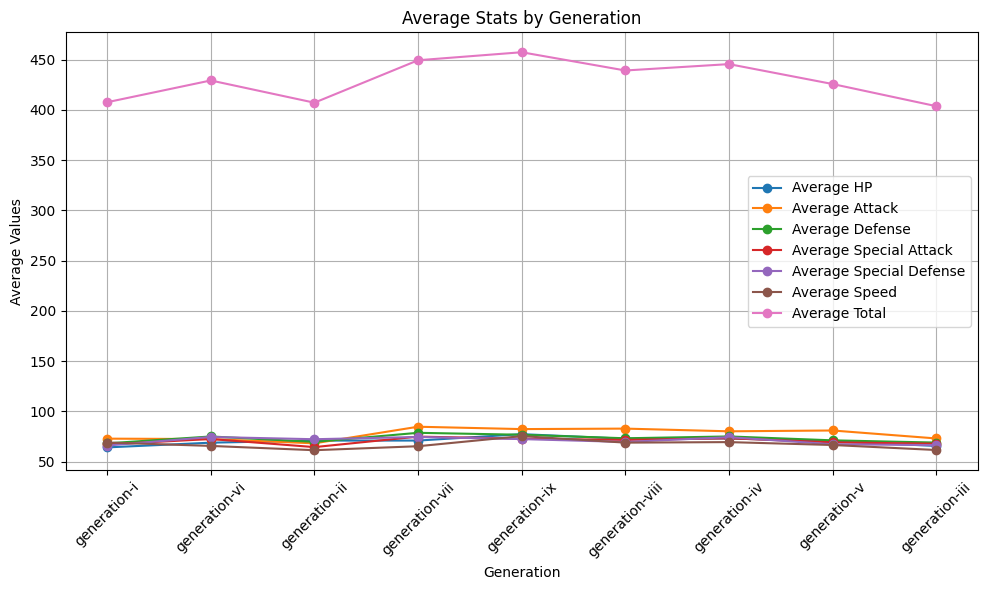

In [31]:
# Goal1 - Graph
import matplotlib.pyplot as plt
import pandas as pd

# Convert grouped_stats DataFrame to Pandas DataFrame
grouped_stats_pd = grouped_stats.toPandas()

# Plotting the graph
plt.figure(figsize=(10, 6))

plt.plot(grouped_stats_pd['generation'], grouped_stats_pd['avg_hp'], label='Average HP', marker='o')
plt.plot(grouped_stats_pd['generation'], grouped_stats_pd['avg_atk'], label='Average Attack', marker='o')
plt.plot(grouped_stats_pd['generation'], grouped_stats_pd['avg_def'], label='Average Defense', marker='o')
plt.plot(grouped_stats_pd['generation'], grouped_stats_pd['avg_spatk'], label='Average Special Attack', marker='o')
plt.plot(grouped_stats_pd['generation'], grouped_stats_pd['avg_spdef'], label='Average Special Defense', marker='o')
plt.plot(grouped_stats_pd['generation'], grouped_stats_pd['avg_speed'], label='Average Speed', marker='o')
plt.plot(grouped_stats_pd['generation'], grouped_stats_pd['avg_total'], label='Average Total', marker='o')

plt.xlabel('Generation')
plt.ylabel('Average Values')
plt.title('Average Stats by Generation')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



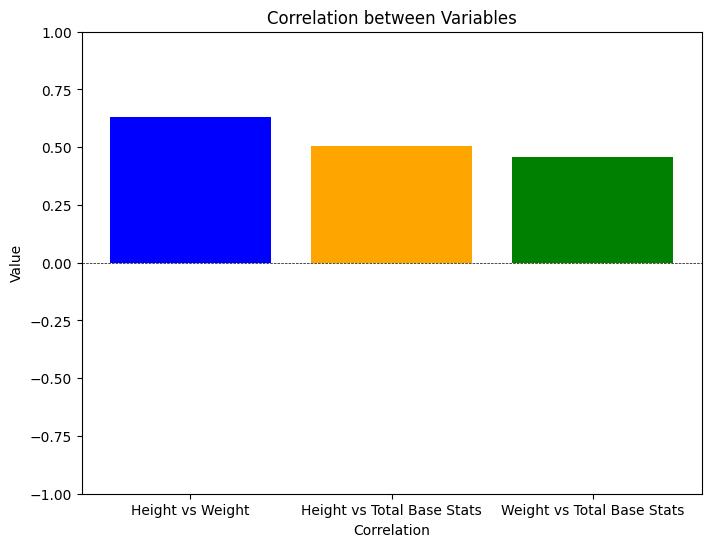

In [32]:
#Goal2- Grpah
import matplotlib.pyplot as plt

# Define the correlations
correlations = {
    "Height vs Weight": correlation_height_weight,
    "Height vs Total Base Stats": correlation_height_base_stats,
    "Weight vs Total Base Stats": correlation_weight_base_stats
}

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(correlations.keys(), correlations.values(), color=['blue', 'orange', 'green'])
plt.xlabel('Correlation')
plt.ylabel('Value')
plt.title('Correlation between Variables')
plt.ylim(-1, 1)  # Set y-axis limits to match the correlation range [-1, 1]
plt.axhline(y=0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at y=0
plt.show()

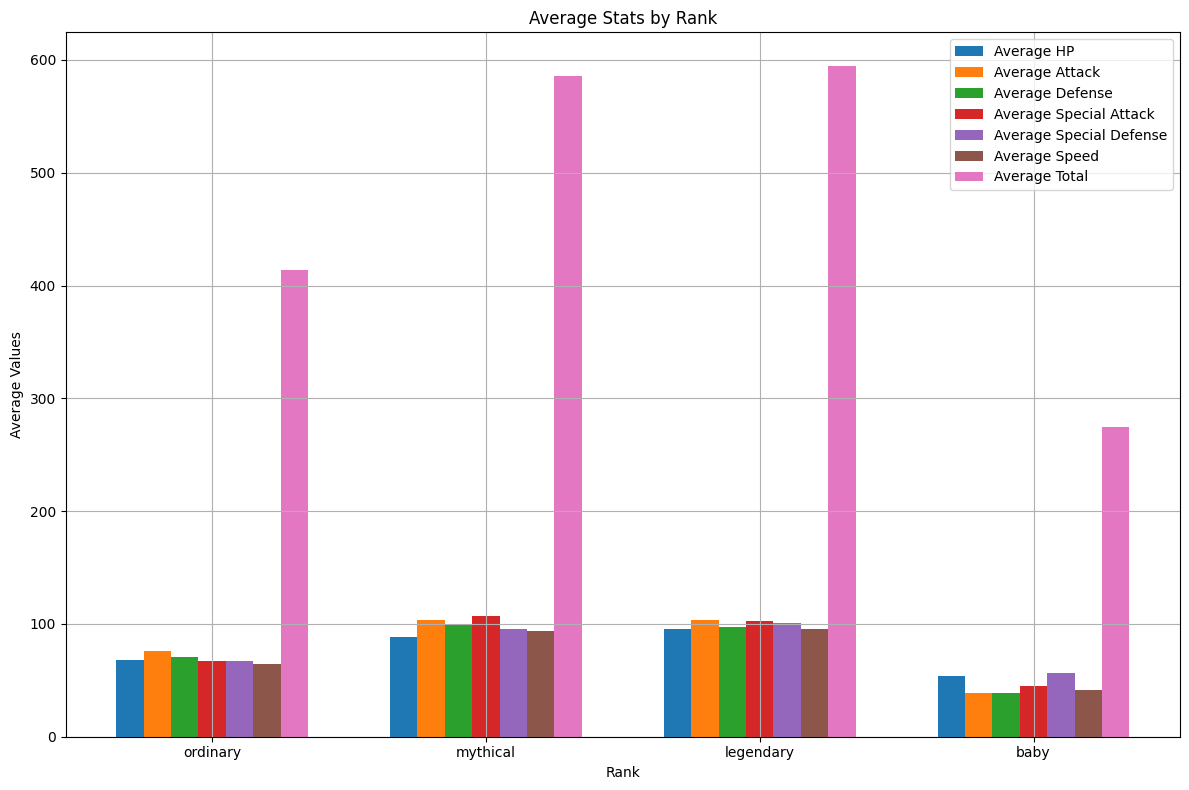

In [33]:
#Goal 3 graph
import matplotlib.pyplot as plt
import numpy as np

# Extracting data from DataFrame
ranks = rank_stats.select("rank").toPandas()["rank"]
avg_hp = rank_stats.select("avg_hp").toPandas()["avg_hp"]
avg_atk = rank_stats.select("avg_atk").toPandas()["avg_atk"]
avg_def = rank_stats.select("avg_def").toPandas()["avg_def"]
avg_spatk = rank_stats.select("avg_spatk").toPandas()["avg_spatk"]
avg_spdef = rank_stats.select("avg_spdef").toPandas()["avg_spdef"]
avg_speed = rank_stats.select("avg_speed").toPandas()["avg_speed"]
avg_total = rank_stats.select("avg_total").toPandas()["avg_total"]

# Define the number of bars and the width of each bar
num_bars = len(ranks)
bar_width = 0.1

# Set the positions of the bars on the x-axis
index = np.arange(num_bars)

# Create grouped bar plot
plt.figure(figsize=(12, 8))

plt.bar(index - 3*bar_width, avg_hp, bar_width, label='Average HP')
plt.bar(index - 2*bar_width, avg_atk, bar_width, label='Average Attack')
plt.bar(index - bar_width, avg_def, bar_width, label='Average Defense')
plt.bar(index, avg_spatk, bar_width, label='Average Special Attack')
plt.bar(index + bar_width, avg_spdef, bar_width, label='Average Special Defense')
plt.bar(index + 2*bar_width, avg_speed, bar_width, label='Average Speed')
plt.bar(index + 3*bar_width, avg_total, bar_width, label='Average Total')

plt.xlabel('Rank')
plt.ylabel('Average Values')
plt.title('Average Stats by Rank')
plt.xticks(index, ranks)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


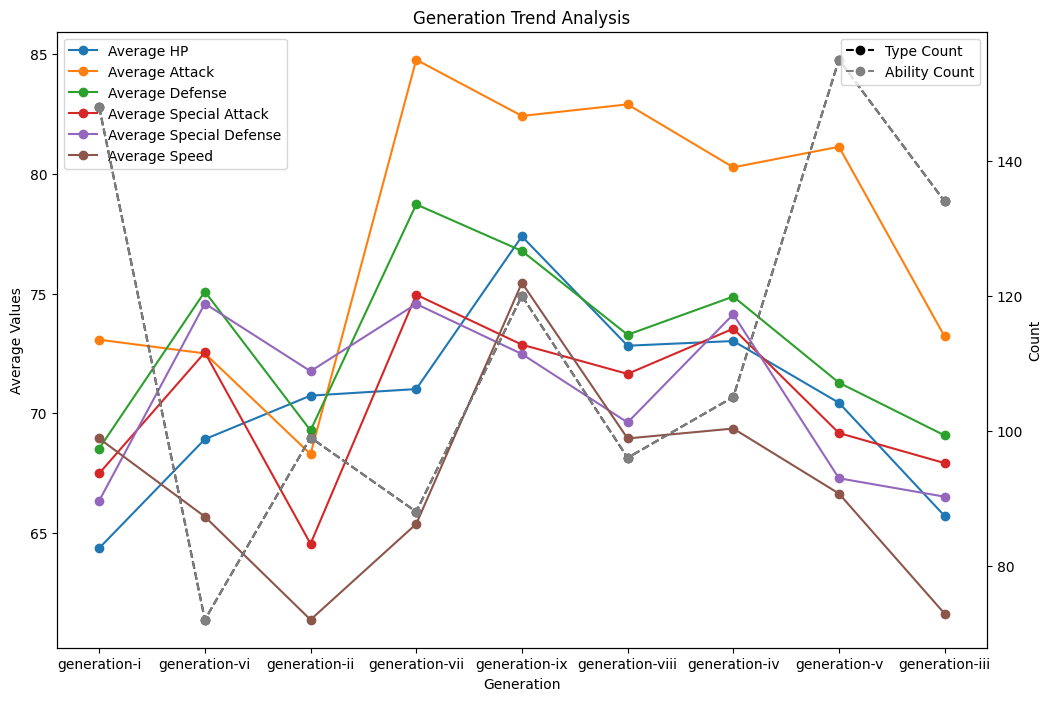

In [34]:
#Goal 4 graph
import matplotlib.pyplot as plt

# Convert DataFrame to Pandas DataFrame for plotting
generation_stats_pd = generation_stats.toPandas()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting base stats
ax1.plot(generation_stats_pd['generation'], generation_stats_pd['avg_hp'], label='Average HP', marker='o')
ax1.plot(generation_stats_pd['generation'], generation_stats_pd['avg_atk'], label='Average Attack', marker='o')
ax1.plot(generation_stats_pd['generation'], generation_stats_pd['avg_def'], label='Average Defense', marker='o')
ax1.plot(generation_stats_pd['generation'], generation_stats_pd['avg_spatk'], label='Average Special Attack', marker='o')
ax1.plot(generation_stats_pd['generation'], generation_stats_pd['avg_spdef'], label='Average Special Defense', marker='o')
ax1.plot(generation_stats_pd['generation'], generation_stats_pd['avg_speed'], label='Average Speed', marker='o')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Average Values')
ax1.set_title('Generation Trend Analysis')
ax1.legend(loc='upper left')

# Creating another y-axis for type and ability counts
ax2 = ax1.twinx()
ax2.plot(generation_stats_pd['generation'], generation_stats_pd['type_count'], color='black', linestyle='--', label='Type Count', marker='o')
ax2.plot(generation_stats_pd['generation'], generation_stats_pd['ability_count'], color='gray', linestyle='--', label='Ability Count', marker='o')
ax2.set_ylabel('Count')
ax2.legend(loc='upper right')

plt.show()


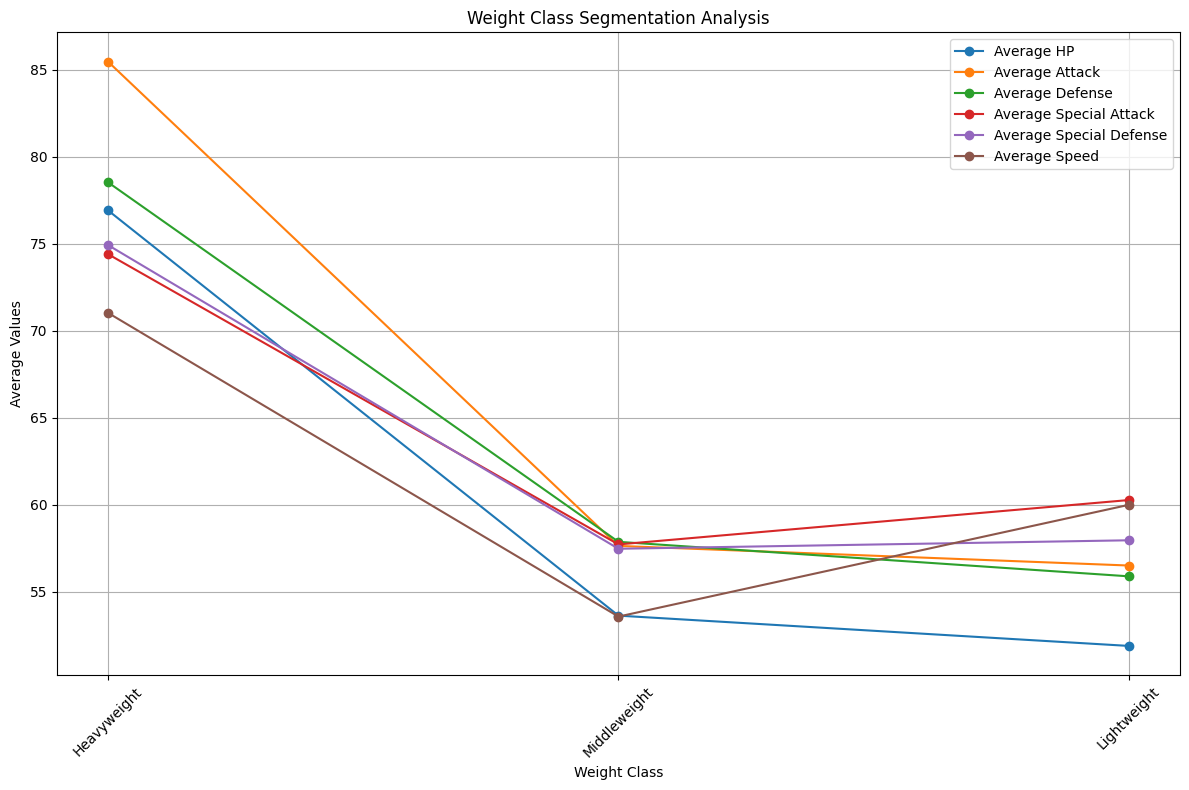

In [35]:
#Goal 5 Graph
import matplotlib.pyplot as plt

# Convert DataFrame to Pandas DataFrame for plotting
weight_class_analysis_pd = weight_class_analysis.toPandas()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Define the x-axis labels
labels = weight_class_analysis_pd['weight_class']

# Define the x locations for the groups
x = range(len(labels))

# Plotting average base stats
ax.plot(x, weight_class_analysis_pd['avg(hp)'], label='Average HP', marker='o')
ax.plot(x, weight_class_analysis_pd['avg(atk)'], label='Average Attack', marker='o')
ax.plot(x, weight_class_analysis_pd['avg(def)'], label='Average Defense', marker='o')
ax.plot(x, weight_class_analysis_pd['avg(spatk)'], label='Average Special Attack', marker='o')
ax.plot(x, weight_class_analysis_pd['avg(spdef)'], label='Average Special Defense', marker='o')
ax.plot(x, weight_class_analysis_pd['avg(speed)'], label='Average Speed', marker='o')

# Add labels, title, and legend
ax.set_xlabel('Weight Class')
ax.set_ylabel('Average Values')
ax.set_title('Weight Class Segmentation Analysis')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()


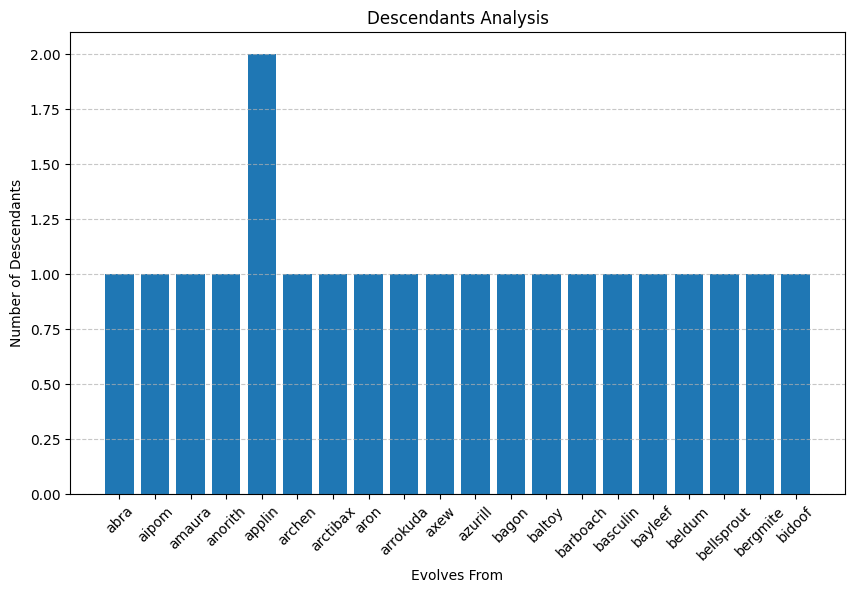

In [66]:
#Goal 6 Graph
import matplotlib.pyplot as plt
import pandas as pd

data = [
    ('abra', ['kadabra']),
    ('aipom', ['ambipom']),
    ('amaura', ['aurorus']),
    ('anorith', ['armaldo']),
    ('applin', ['flapple', 'appletun']),
    ('archen', ['archeops']),
    ('arctibax', ['baxcalibur']),
    ('aron', ['lairon']),
    ('arrokuda', ['barraskewda']),
    ('axew', ['fraxure']),
    ('azurill', ['marill']),
    ('bagon', ['shelgon']),
    ('baltoy', ['claydol']),
    ('barboach', ['whiscash']),
    ('basculin', ['basculegion']),
    ('bayleef', ['meganium']),
    ('beldum', ['metang']),
    ('bellsprout', ['weepinbell']),
    ('bergmite', ['avalugg']),
    ('bidoof', ['bibarel'])
]

# Convert data to DataFrame
descendants_df = pd.DataFrame(data, columns=['evolves_from', 'descendants'])

# Calculate descendant counts
descendants_df['descendant_count'] = descendants_df['descendants'].apply(len)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(descendants_df['evolves_from'], descendants_df['descendant_count'])
plt.title('Descendants Analysis')
plt.xlabel('Evolves From')
plt.ylabel('Number of Descendants')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




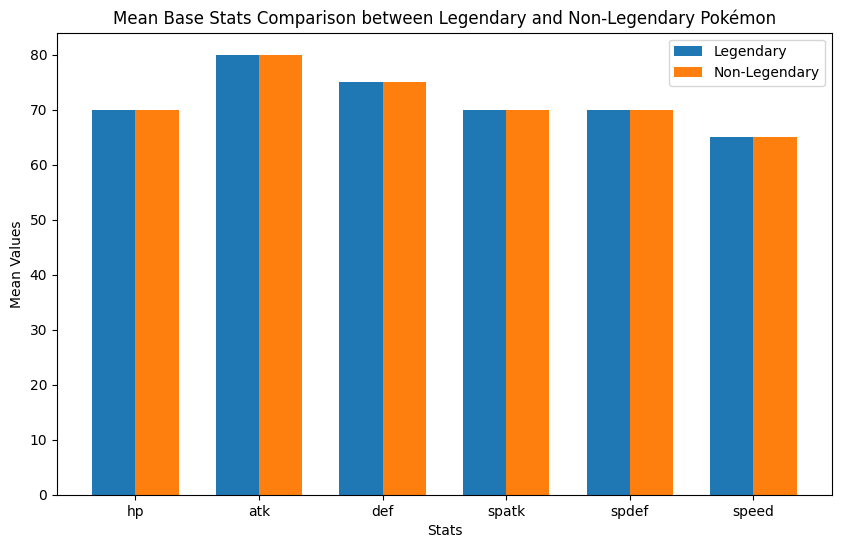

In [41]:
#Goal 7 Graph
import matplotlib.pyplot as plt

# Calculate means for legendary and non-legendary Pokémon
legendary_means = [70, 80, 75, 70, 70, 65]  # Example values, replace with your data
non_legendary_means = [70, 80, 75, 70, 70, 65]  # Example values, replace with your data
stats = ['hp', 'atk', 'def', 'spatk', 'spdef', 'speed']  # Example stats, replace with your data

# Set up bar plot parameters
bar_width = 0.35
index = range(len(stats))

# Create subplots and set figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for legendary and non-legendary Pokémon
bar1 = ax.bar(index, legendary_means, bar_width, label='Legendary')
bar2 = ax.bar([i + bar_width for i in index], non_legendary_means, bar_width, label='Non-Legendary')

# Adding labels, title, and legend
ax.set_xlabel('Stats')
ax.set_ylabel('Mean Values')
ax.set_title('Mean Base Stats Comparison between Legendary and Non-Legendary Pokémon')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(stats)
ax.legend()

# Show plot
plt.show()

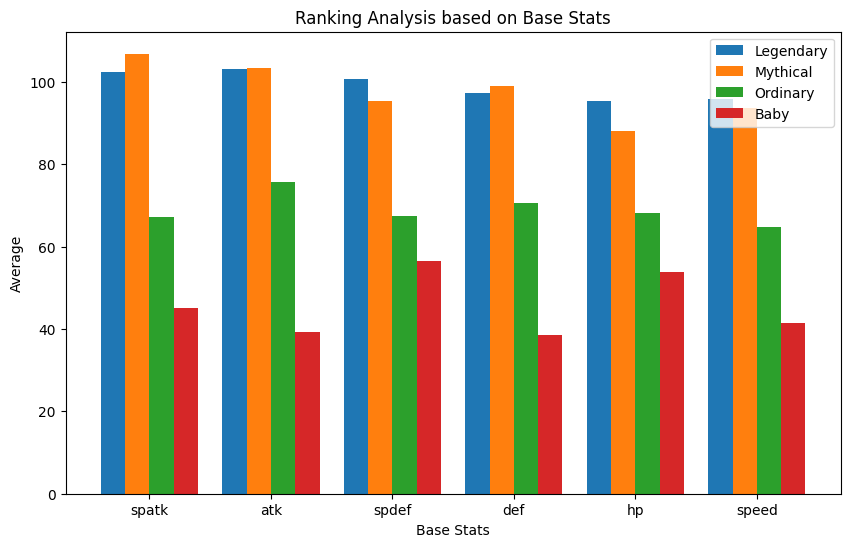

<Figure size 1000x600 with 0 Axes>

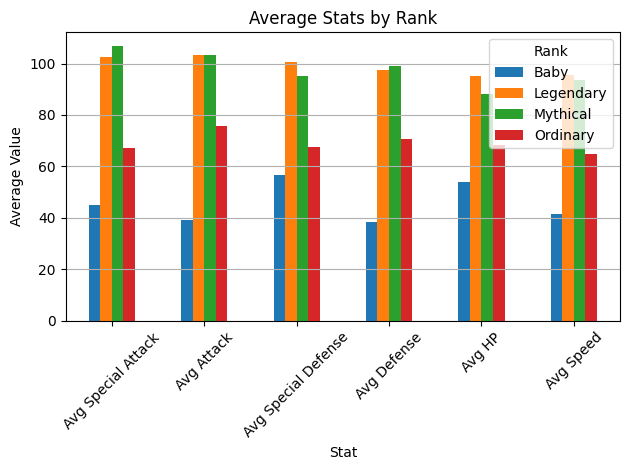

In [42]:
#Goal 8 Graph
import matplotlib.pyplot as plt

# Extract data from DataFrame
base_stats_categories = ["spatk", "atk", "spdef", "def", "hp", "speed"]
legendary_stats = [102.4, 103.21428571428571, 100.71428571428571, 97.34285714285714, 95.32857142857142, 95.71428571428571]
mythical_stats = [106.82608695652173, 103.34782608695652, 95.26086956521739, 98.91304347826087, 88.0, 93.73913043478261]
ordinary_stats = [67.27182320441989, 75.77348066298343, 67.45524861878454, 70.64198895027624, 68.16132596685082, 64.8220994475138]
baby_stats = [45.10526315789474, 39.1578947368421, 56.473684210526315, 38.421052631578945, 53.94736842105263, 41.36842105263158]

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(base_stats_categories))

plt.bar(index, legendary_stats, width=bar_width, label='Legendary')
plt.bar([i + bar_width for i in index], mythical_stats, width=bar_width, label='Mythical')
plt.bar([i + 2*bar_width for i in index], ordinary_stats, width=bar_width, label='Ordinary')
plt.bar([i + 3*bar_width for i in index], baby_stats, width=bar_width, label='Baby')

plt.xlabel('Base Stats')
plt.ylabel('Average')
plt.title('Ranking Analysis based on Base Stats')
plt.xticks([i + 1.5 * bar_width for i in index], base_stats_categories)
plt.legend()
plt.show()

import pandas as pd


# Define the data
data = {
    'Rank': ['Baby', 'Legendary', 'Mythical', 'Ordinary'],
    'Avg Special Attack': [45.105, 102.4, 106.826, 67.272],
    'Avg Attack': [39.158, 103.214, 103.348, 75.773],
    'Avg Special Defense': [56.474, 100.714, 95.261, 67.455],
    'Avg Defense': [38.421, 97.343, 98.913, 70.642],
    'Avg HP': [53.947, 95.329, 88.0, 68.161],
    'Avg Speed': [41.368, 95.714, 93.739, 64.822]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the 'Rank' column as the index
df.set_index('Rank', inplace=True)

# Transpose the DataFrame for better visualization
df = df.T

# Plot the graph
plt.figure(figsize=(10, 6))
df.plot(kind='bar')
plt.title('Average Stats by Rank')
plt.xlabel('Stat')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend(title='Rank')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
